In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
from awesome.run.awesome_config import AwesomeConfig
from awesome.run.awesome_runner import AwesomeRunner
from awesome.util.reflection import class_name
from awesome.analytics.result_model import ResultModel
from awesome.util.path_tools import get_project_root_path, get_package_root_path
from awesome.util.logging import basic_config
import os
import torch
import numpy as np
import re
from awesome.util.format import latex_postprocessor
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from awesome.run.functions import saveable
from matplotlib.colors import to_hex
from colour import Color
basic_config()

os.chdir(get_project_root_path()) # Beeing in the root directory of the project is important for the relative paths to work consistently

D:\projects\AWESOME\awesome\agent\torch_agent.py:20: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


## Teaser Implicit Figure

In [2]:
path = "./runs/fbms_local/eval/unet/joint_realnvp/2024-01-11/#16_UNET+horses01+edge+diffeo+original+joint_24_01_11_17_06_14"

result_model = ResultModel.from_path(path)

In [3]:
runner = result_model.get_runner(-1)

c:\Users\Schneider\AppData\Local\pypoetry\Cache\virtualenvs\awesome-dC4phDSK-py3.9\lib\site-packages\torch\functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\TensorShape.cpp:3484.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
2024-01-23:19:21:36.639 INFO     [tensorboard.py:55] Tensorboard logger created at: runs\fbms_local\eval\unet\joint_realnvp\2024-01-11\#16_UNET+horses01+edge+diffeo+original+joint_24_01_11_17_06_14
2024-01-23:19:21:48.777 WARNING  [awesome_runner.py:150] Patch Agent is currently not fully implemented!


In [13]:
from awesome.run.functions import count_parameters
import pandas as pd

def get_model_size(model: ResultModel) -> int:
    runner = model.get_runner(0)
    agent = runner.agent
    model = agent._get_model()
    segm = pd.DataFrame(count_parameters(model.segmentation_module))
    prior = pd.DataFrame(count_parameters(model.prior_module.flow_net))
    prior_c = pd.DataFrame(count_parameters(model.prior_module.convex_net))
    return segm, prior, prior_c

print(get_model_size(result_model)[0][["name", "learnable_params"]].to_markdown())

|    | name                         |   learnable_params |
|---:|:-----------------------------|-------------------:|
|  0 | inc.conv.conv.0.weight       |               2304 |
|  1 | inc.conv.conv.0.bias         |                 64 |
|  2 | inc.conv.conv.1.weight       |                 64 |
|  3 | inc.conv.conv.1.bias         |                 64 |
|  4 | inc.conv.conv.3.weight       |              36864 |
|  5 | inc.conv.conv.3.bias         |                 64 |
|  6 | inc.conv.conv.4.weight       |                 64 |
|  7 | inc.conv.conv.4.bias         |                 64 |
|  8 | down1.mpconv.1.conv.0.weight |              73728 |
|  9 | down1.mpconv.1.conv.0.bias   |                128 |
| 10 | down1.mpconv.1.conv.1.weight |                128 |
| 11 | down1.mpconv.1.conv.1.bias   |                128 |
| 12 | down1.mpconv.1.conv.3.weight |             147456 |
| 13 | down1.mpconv.1.conv.3.bias   |                128 |
| 14 | down1.mpconv.1.conv.4.weight |                128

In [4]:
from awesome.run.functions import get_result, plot_image_scribbles, image_subsample
model = runner.agent._get_model()
dataloader = runner.dataloader
dataset_name = dataloader.__dataset__.dataset_name

D:\projects\AWESOME\awesome\util\matplotlib.py:118: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  out.tight_layout()


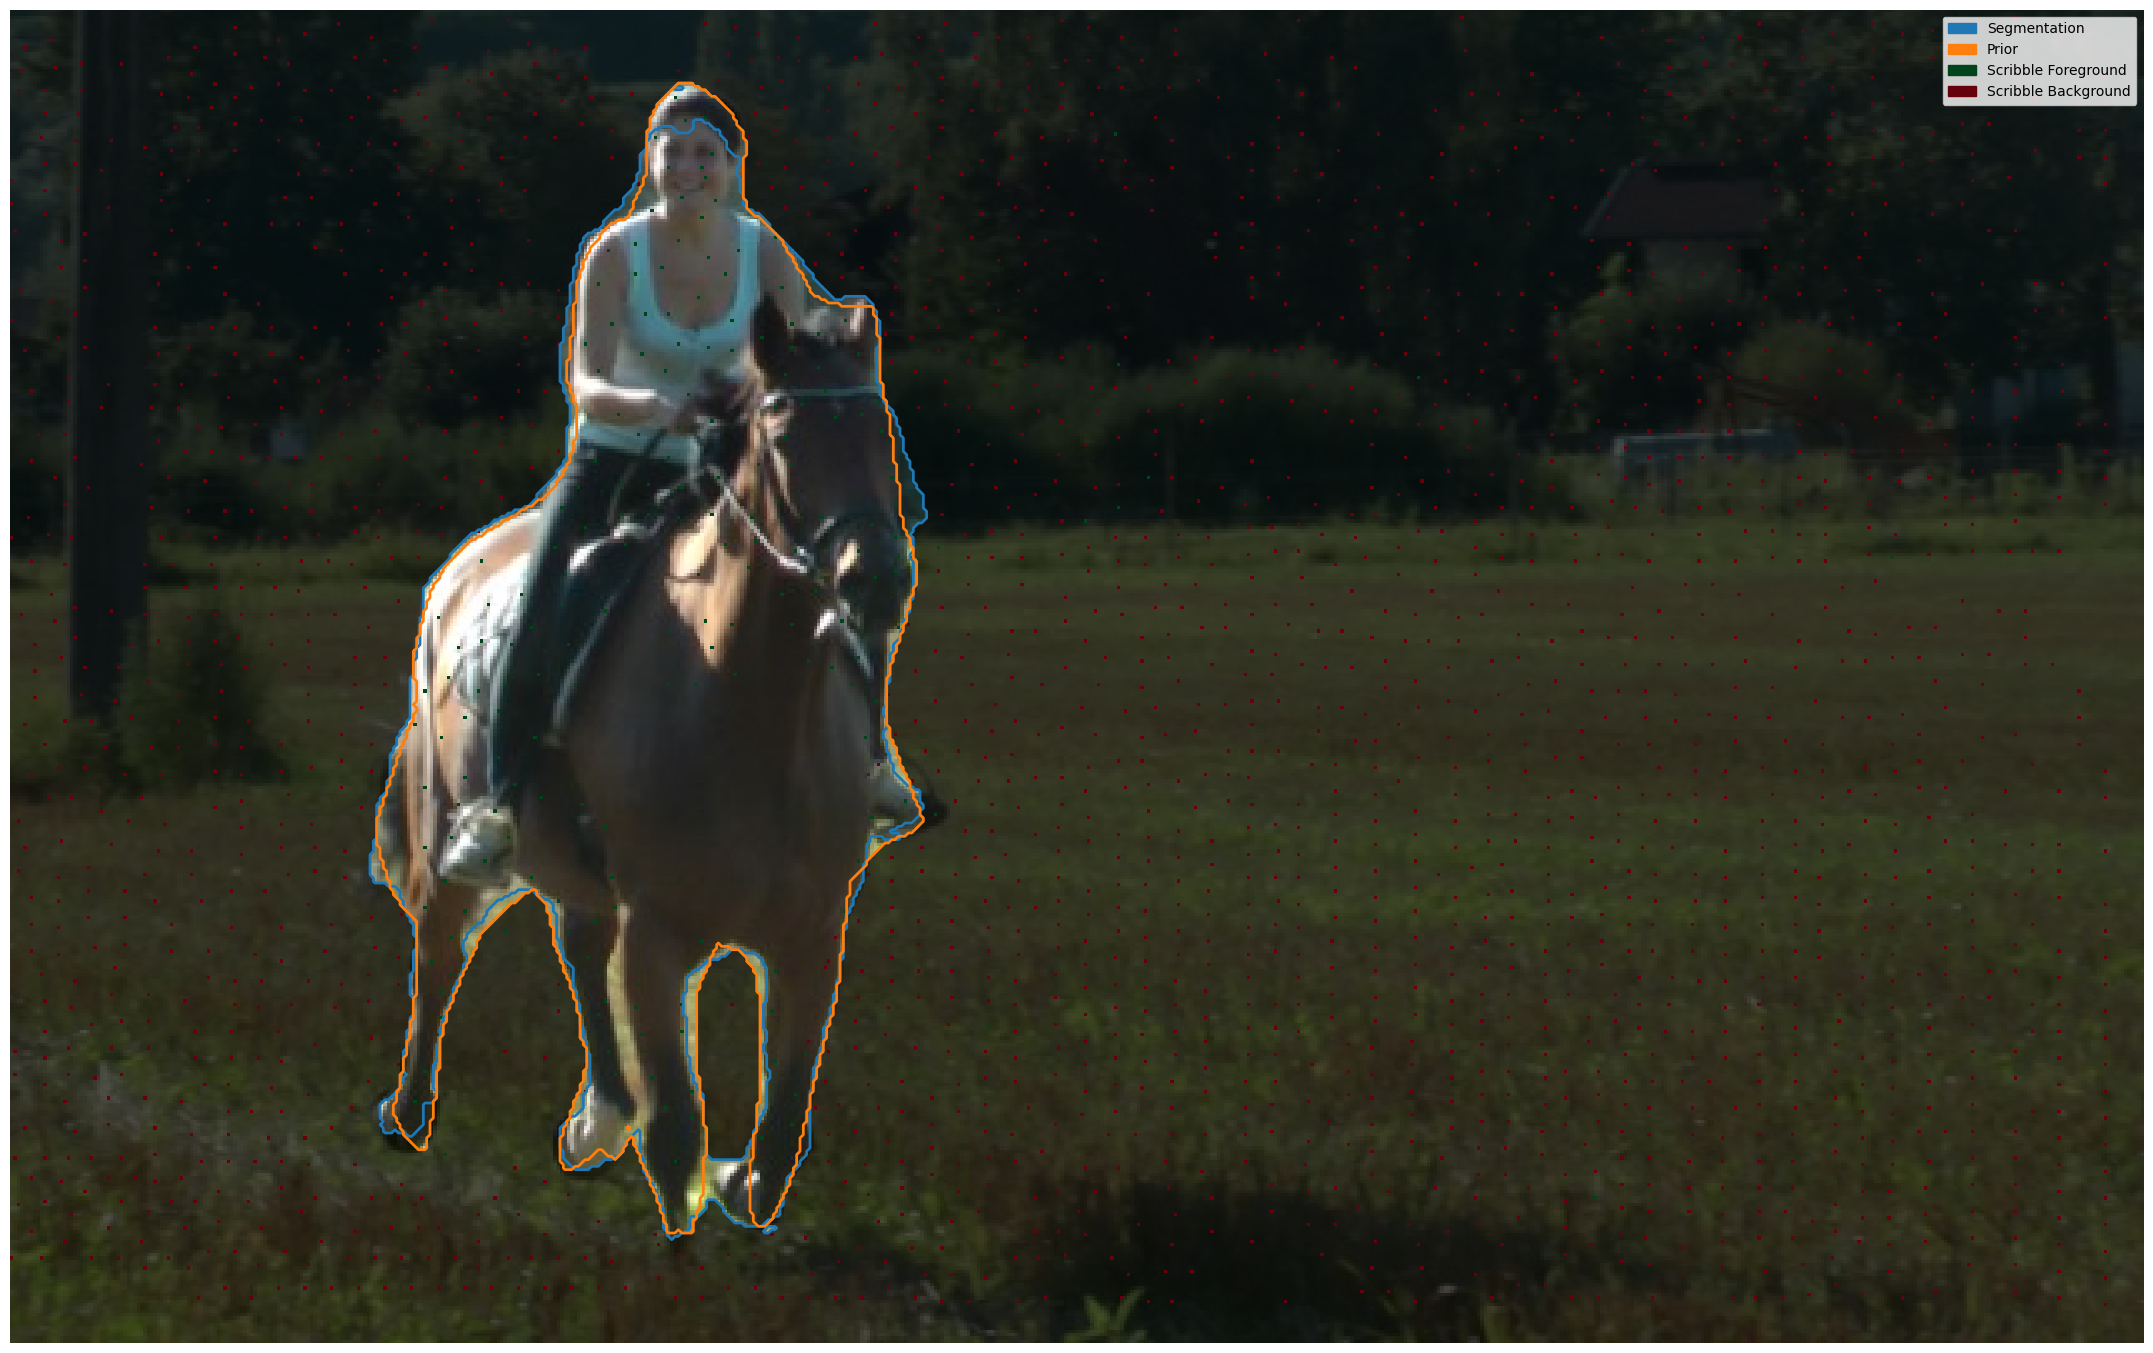

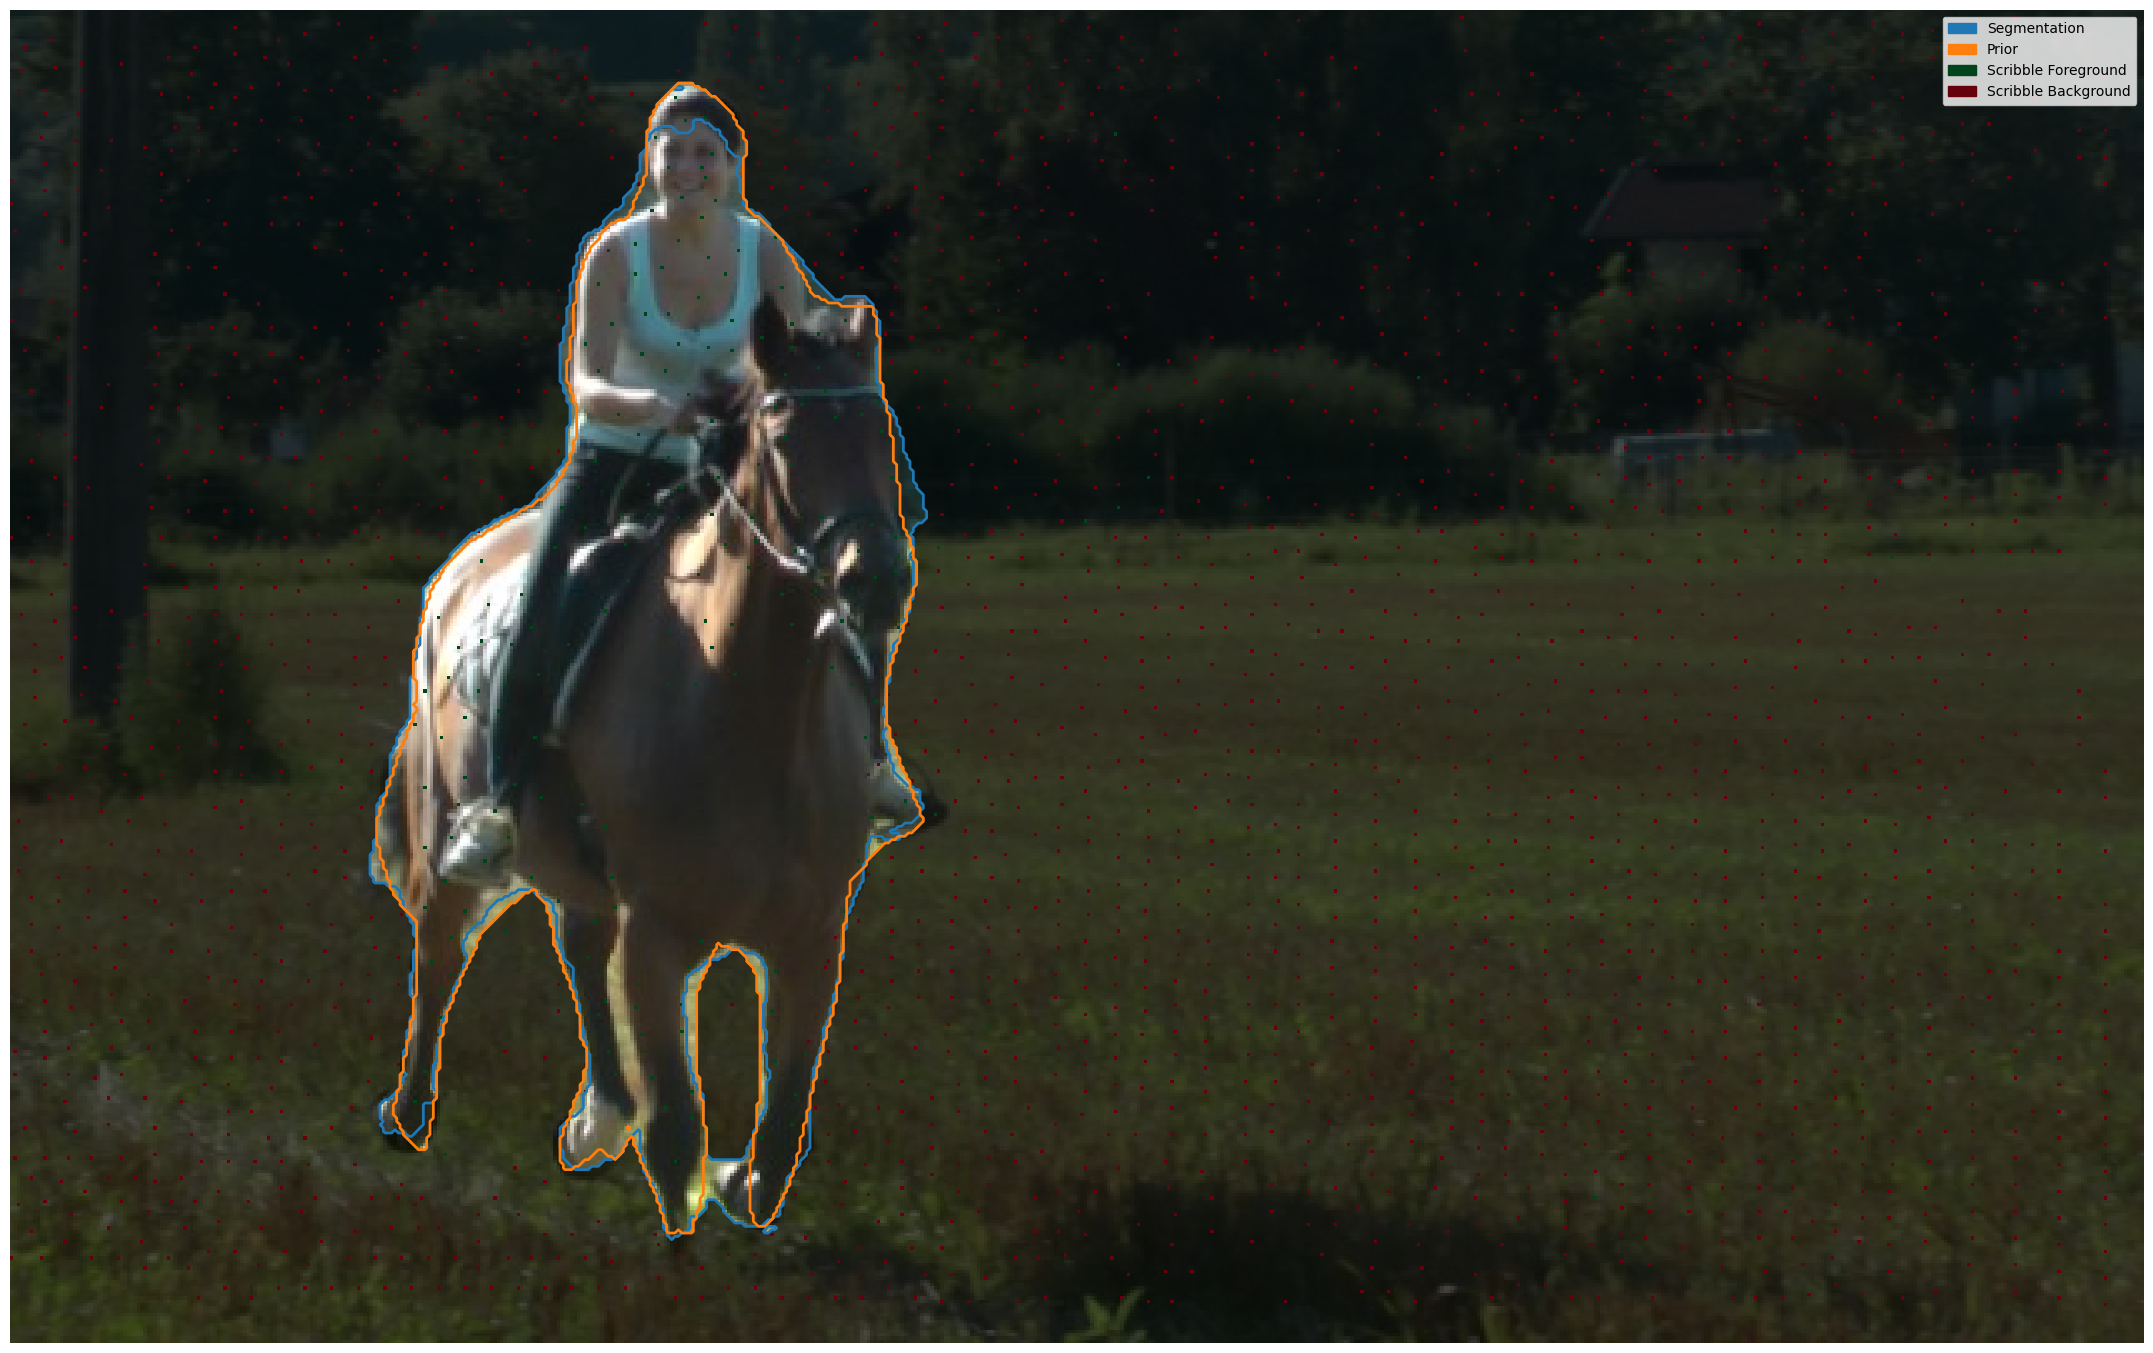

In [5]:
from awesome.run.functions import get_result, plot_image_scribbles, split_model_result, prepare_input_eval
from awesome.util.temporary_property import TemporaryProperty

index = 162

res, ground_truth, img, fg, bg = get_result(model, dataloader, index, model_gets_targets=False)
res = split_model_result(res, model, dataloader, img, compute_crf=False)


with TemporaryProperty(model, use_prior_sigmoid=False):
    _wo_s = get_result(model, dataloader, index, model_gets_targets=False)
    res_hull = _wo_s[0][0, 1, ...][None, ...]

img_no_blur = True
with TemporaryProperty(dataloader, do_image_blurring=False, image_channel_format="rgb"):
    sample = dataloader.__images__[dataloader.get_data_index(index)]
    with TemporaryProperty(sample.sample, do_weak_label_preprocessing=False):
        img_no_blur, _, _, _, fg_no_proc, bg_no_proc, _ = prepare_input_eval(dataloader, model, index)
plot_image_scribbles(img_no_blur, res.get("segmentation"), fg_no_proc, bg_no_proc, res.get("prior"), size=10, tight_layout=True, tight=True)

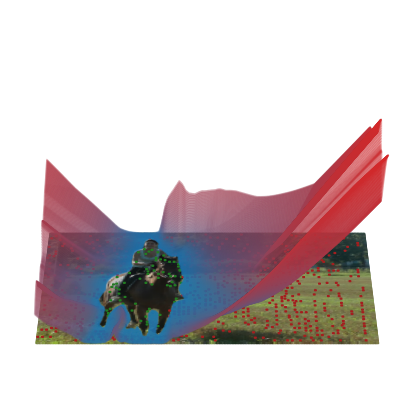

In [33]:

from awesome.run.functions import plot_surface_logits


img_sub = image_subsample(img_no_blur, 6)
fg_sub = image_subsample(fg_no_proc[None, ...], 6)
bg_sub = image_subsample(bg_no_proc[None, ...], 6)

res_hull_sub =  image_subsample(res_hull, 3)

thresh = 0.1
bg_sub = (bg_sub > thresh).float()
fg_sub = (fg_sub > thresh).float()

fig = plot_surface_logits(img_sub, res_hull_sub, fg_sub, bg_sub, 
                          save=True, 
                          override=True, 
                          transparent=True, 
                          path=f"./notebooks/output/intro_figures/teaser_implicit_pc_{dataset_name}_{index}", ext=["png", "pdf"], 
                          image_subsampling=1,
                          surface_log=True,
                          surface_log_eps=1e-2,
                          zoom=1.3)
display(fig)
plt.close(fig)


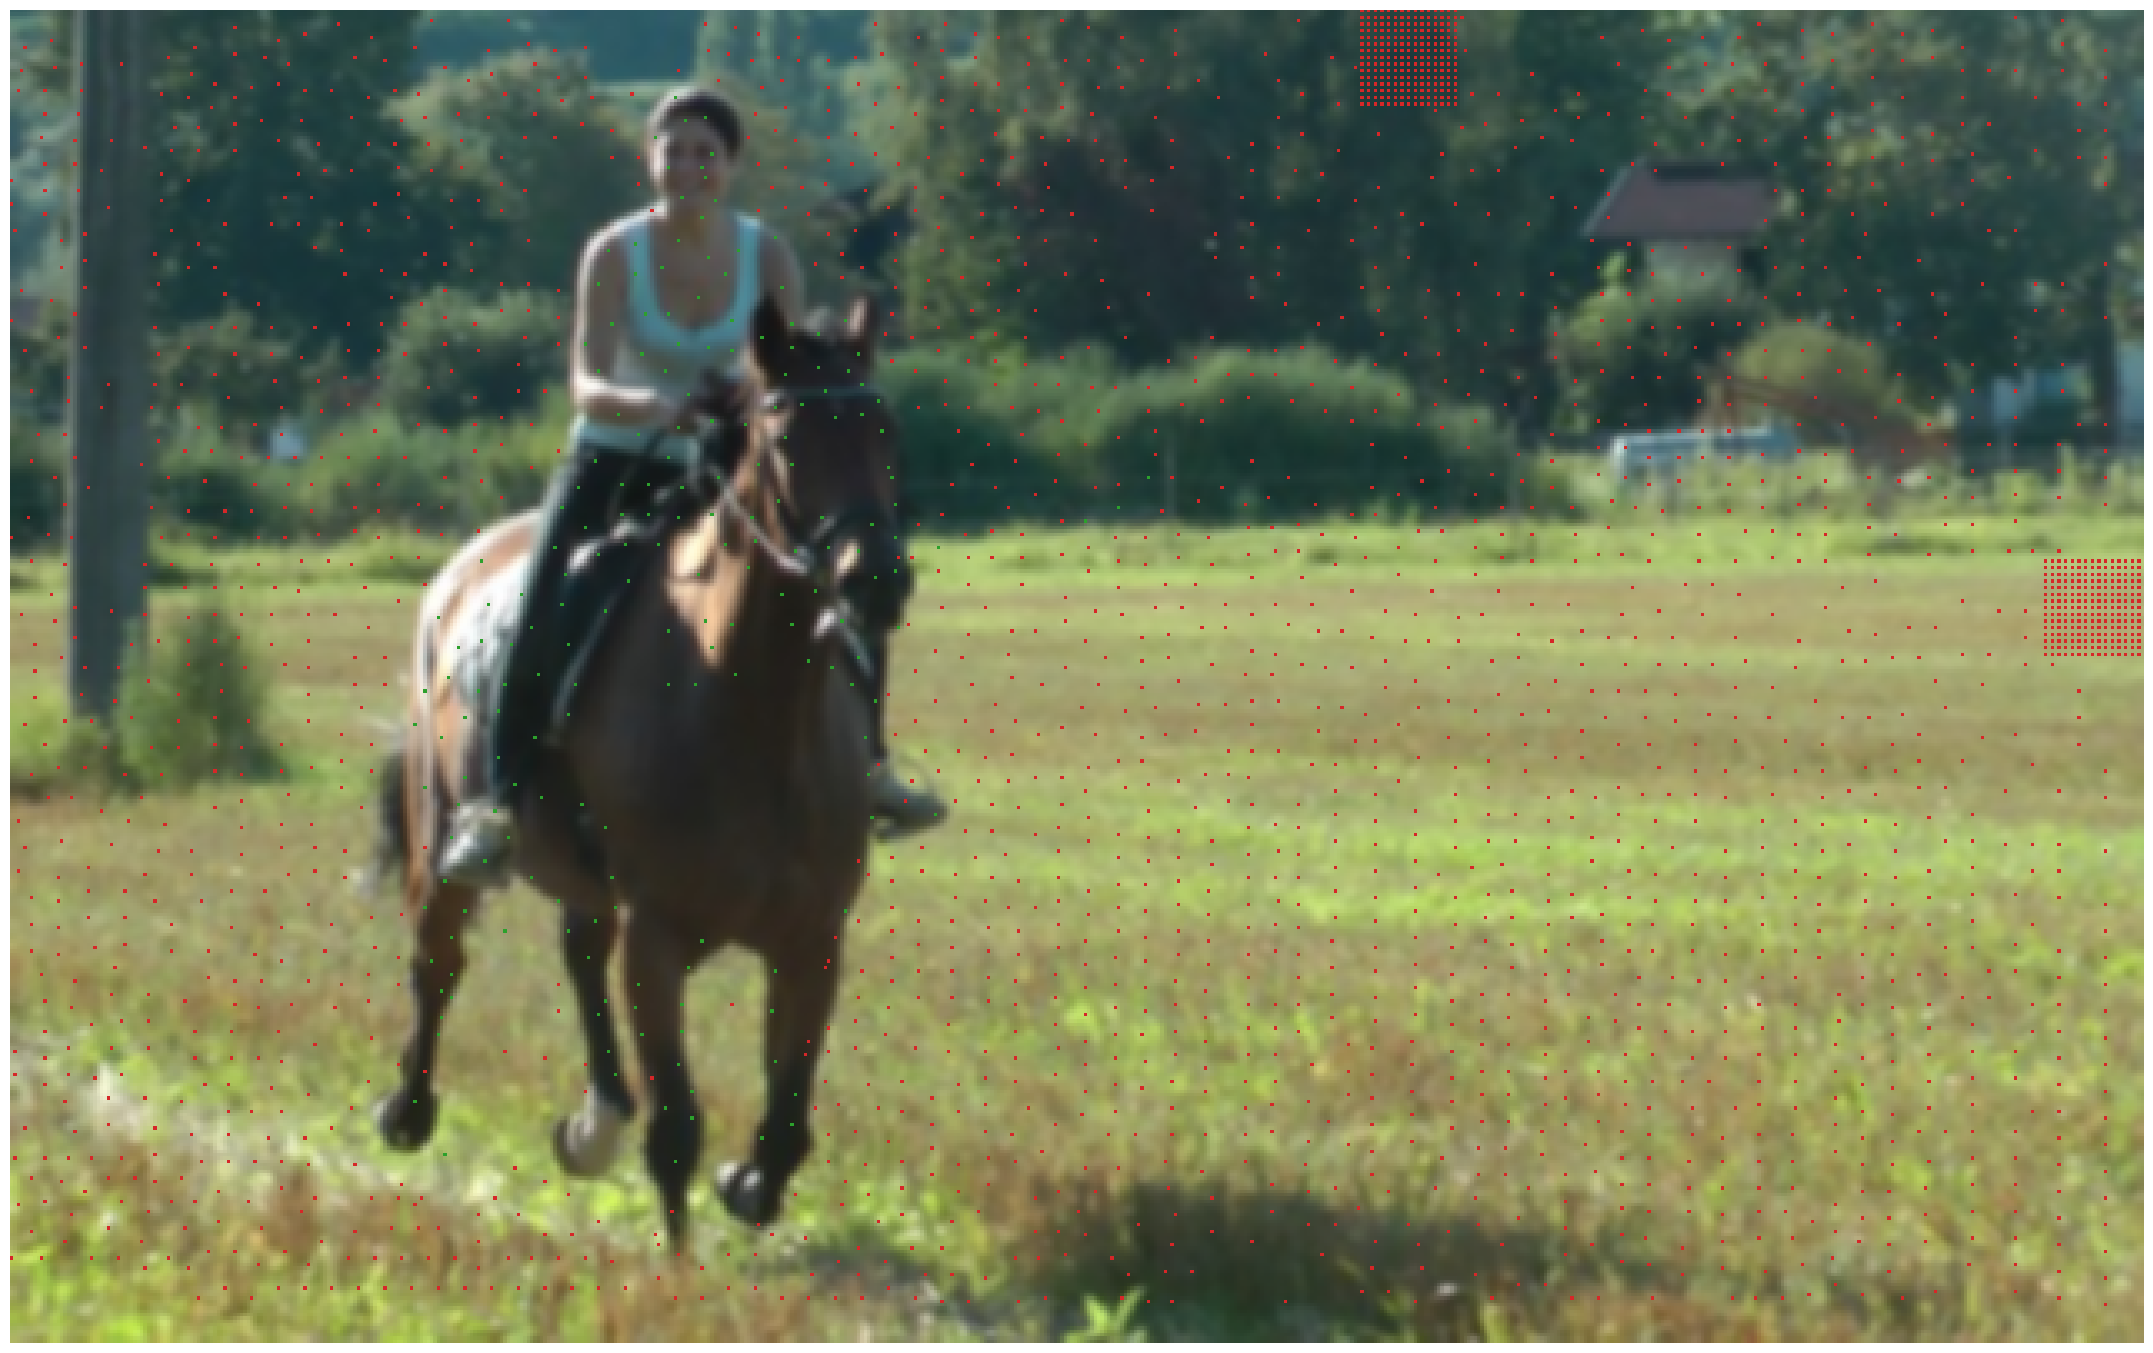

In [37]:
from typing import Optional
from awesome.run.functions import register_alpha_colormap, create_alpha_colormap
from awesome.util.matplotlib import saveable


@saveable()
def plot_scribble_mask(img, fg, bg, color_fg: Optional[str] = None, color_bg: Optional[str] = None):
    register_alpha_colormap(color_fg, "tab10_green_alpha")
    register_alpha_colormap(color_bg, "tab10_red_alpha")

    size = 10
    tight = True

    if color_fg is None:
        color_fg = plt.get_cmap("tab10").colors[2]
    if color_bg is None:
        color_bg = plt.get_cmap("tab10").colors[3]

    sizes = img.shape[1:]
    fig = plt.figure(figsize=(size, size))
    dpi = 300
    fig.set_size_inches(size * (sizes[1] / dpi), size * (sizes[0] / dpi), forward=False)
    ax = plt.Axes(fig, [0., 0., 1., 1.])
    ax.set_axis_off()
    fig.add_axes(ax)


    ax.imshow(img.permute(1, 2, 0).numpy())

    fg_cmap = create_alpha_colormap("fg", color_fg)
    bg_cmap = create_alpha_colormap("bg", color_bg)

    fgh = ax.imshow(fg, cmap=fg_cmap)
    bgh = ax.imshow(bg, cmap=bg_cmap)

    ax.axis('off')
    return fig
fig = plot_scribble_mask(img, fg, bg, save=True, override=True, transparent=True, path="./notebooks/output/intro_figures/teaser_scribbles_path_connected", ext=["png", "pdf"])
display(fig)
plt.close(fig)	

C:\Users\Schneider\AppData\Local\Temp\ipykernel_16816\3056942212.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  sub_fg = image_subsample(torch.tensor(fg.unsqueeze(0).float()), subsample_factor)[0]
C:\Users\Schneider\AppData\Local\Temp\ipykernel_16816\3056942212.py:78: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  sub_bg = image_subsample(torch.tensor(bg.unsqueeze(0).float()), subsample_factor)[0]
D:\projects\AWESOME\awesome\util\matplotlib.py:118: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  out.tight_layout()


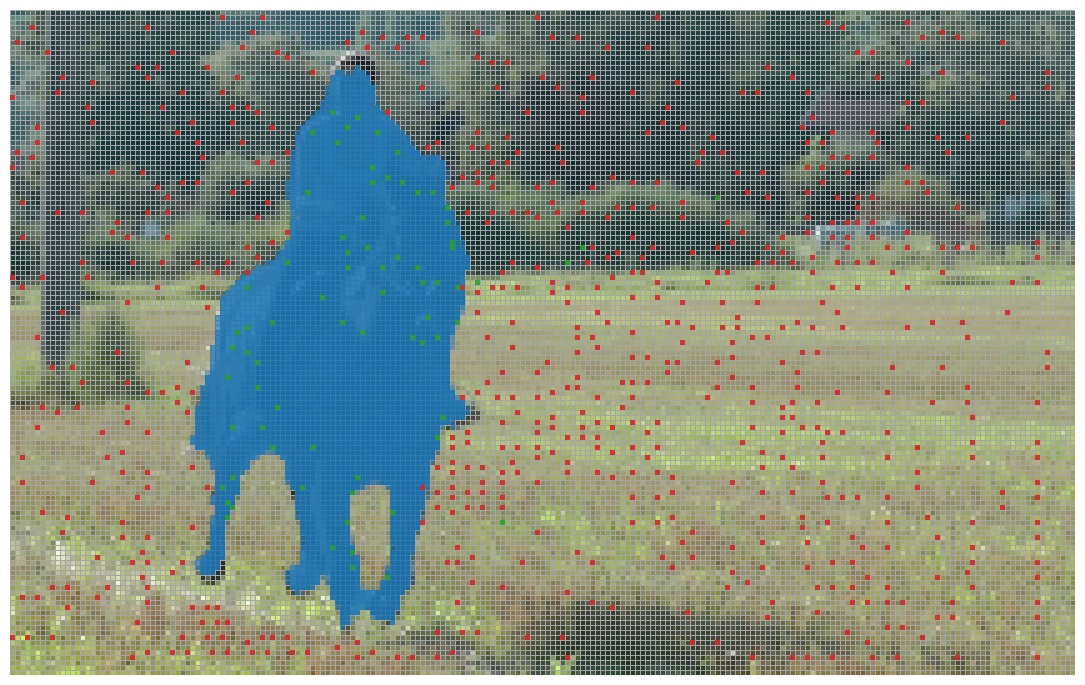

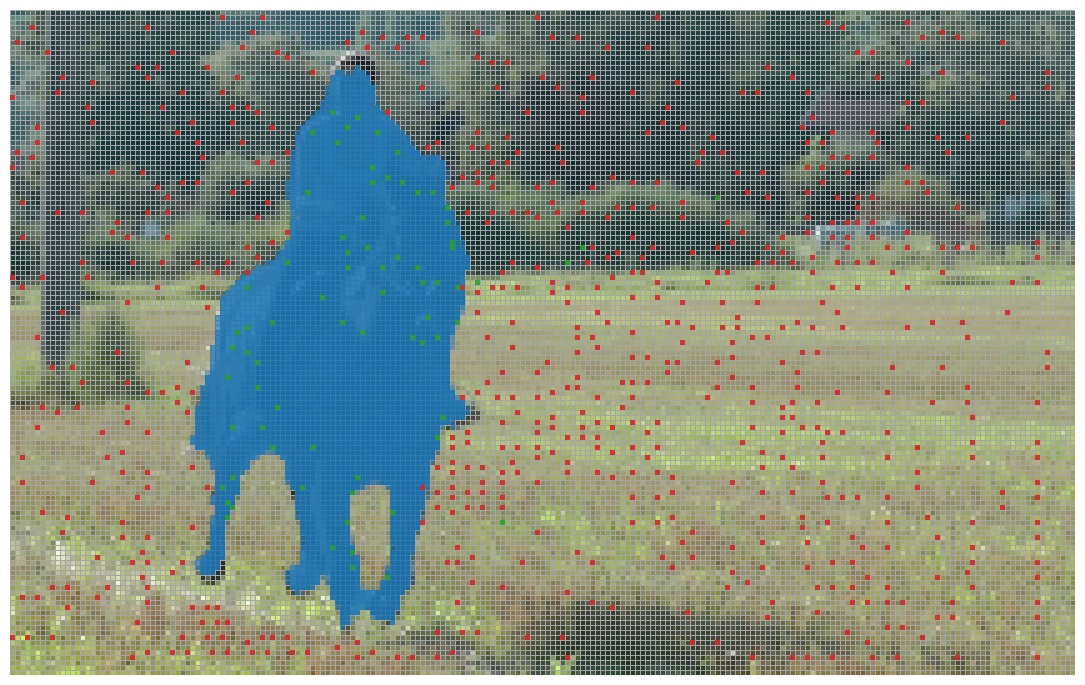

In [42]:
from typing import Literal
from scipy.interpolate import interp2d
import torch.nn.functional as F
import torch


def image_subsample(img: torch.Tensor, factor: int = 6, mode: Literal["grid_sample", "slicing"] = "grid_sample"):
    if mode == "grid_sample":
        x = torch.arange(-1, 1, factor / img.shape[-2])
        y = torch.arange(-1, 1, factor / img.shape[-1])
        xx, yy = torch.meshgrid(x, y)
        flowgrid = torch.stack((yy, xx), dim=-1).float()[None,...]
        return F.grid_sample(img[None,...], flowgrid, align_corners=True)[0, ...]
    elif mode == "slicing":
        return img[..., ::factor, ::factor]
    else:
        raise ValueError("Invalid mode")

@saveable()
def plot_grid_prediction(image, 
                         res_hull_disc, 
                         fg, 
                         bg, 
                         subsample_factor: int = 6,
                         color_fg = None, 
                         color_bg = None, 
                         color_seg = None, 
                         size: float = 5,
                         tight: bool = True):
    if color_fg is None:
        color_fg = plt.get_cmap("tab10").colors[2]
    if color_bg is None:
        color_bg = plt.get_cmap("tab10").colors[3]
    if color_seg is None:
        color_seg = plt.get_cmap("tab10").colors[0]
   
    thresh = 0.1

    subsampled_image = image_subsample(image, subsample_factor).permute(1, 2, 0)
    extent = (0, subsampled_image.shape[1], subsampled_image.shape[0], 0)

    fig = plt.figure(figsize=(size, size))

    #x_ext = sizes[1] / dpi, sizes[0] / dpi
    if tight:
        sizes = subsampled_image.shape[:2]
        dpi = 300
        fig.set_size_inches(15 * (sizes[1]-1) / dpi, 15 * (sizes[0]-1) / dpi, forward = False)
    
    ax = plt.Axes(fig, [0., 0., 1, 1])
    
    ax.set_axis_off()
    ax = fig.add_axes(ax, computed_zorder=False)
    
    ax.imshow(subsampled_image, extent=extent)

    ax.pcolormesh(subsampled_image, edgecolors="#a2a6ab", linewidth=.5, facecolors='none',rasterized=True, zorder=0)

    res_hull_color = np.zeros(res_hull_disc.shape + (4,), dtype=np.float32)
    res_hull_color[..., 0:3] = color_seg

    alpha = .9
    res_hull_color[..., 3] = (1 - res_hull_disc.squeeze().numpy()) * alpha

    subsampled_img = image_subsample(torch.tensor(res_hull_color).permute(2, 0, 1), subsample_factor).permute(1, 2, 0)
    ax.imshow(subsampled_img, extent=extent)


    sub_fg = image_subsample(torch.tensor(fg.unsqueeze(0).float()), subsample_factor)[0]
    sub_fg = (sub_fg > thresh).float()
    fg_pred_color = np.zeros(sub_fg.shape + (4,), dtype=np.float32)
    fg_pred_color[..., 0:3] = color_fg
    alpha_fg_scribble = .9
    fg_pred_color[..., 3] = sub_fg * alpha_fg_scribble
    ax.imshow(fg_pred_color, extent=extent)


    sub_bg = image_subsample(torch.tensor(bg.unsqueeze(0).float()), subsample_factor)[0]
    sub_bg = (sub_bg > thresh).float()
    bg_pred_color = np.zeros(sub_bg.shape + (4,), dtype=np.float32)
    bg_pred_color[..., 0:3] = color_bg
    alpha_bg_scribble = .9
    bg_pred_color[..., 3] = sub_bg * alpha_bg_scribble
    ax.imshow(bg_pred_color, extent=extent)

    ax.set_ylim(subsampled_image.shape[0]-1, 0)
    ax.set_xlim(0, subsampled_image.shape[1]-1,)
   
    
    x_pos = [i._x for i in ax.get_xticklabels() if i._x <= subsampled_image.shape[1]]
    x_lab = [round((i / subsampled_image.shape[1]), 2) for i in x_pos]
    x_lab = ["" for x in x_lab]
    ax.set_xticks(x_pos, x_lab)

    y_pos = [i._y for i in ax.get_yticklabels() if i._y <= subsampled_image.shape[0]]
    y_lab = [round((i / subsampled_image.shape[0]), 2) for i in y_pos]
    y_lab = ["" for x in y_lab]
    ax.set_yticks(y_pos, y_lab)

    # if tight:
    #     sizes = subsampled_image.shape[:2]
    #     dpi = 300
    #     fig.set_size_inches(15 * (sizes[1] / dpi), 15 * (sizes[0] / dpi), forward = False)
    return fig

fig = plot_grid_prediction(img_no_blur, res.get("segmentation")[0], 
                           fg_no_proc, 
                           bg_no_proc, 
                           subsample_factor=6,
                     save=True,
                     override=True, 
                     tight_layout=True,
                     path=f"./notebooks/output/intro_figures/teaser_image_pc_{dataset_name}_{index}", 
                     tight=True,
                     ext=["png", "pdf"])
fig

In [13]:
img_no_blur.shape

torch.Size([3, 400, 640])

C:\Users\Schneider\AppData\Local\Temp\ipykernel_16816\3931339242.py:45: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  sub_fg = subsample(torch.tensor(fg.unsqueeze(0).float()))[0]
C:\Users\Schneider\AppData\Local\Temp\ipykernel_16816\3931339242.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  sub_bg = subsample(torch.tensor(bg.unsqueeze(0).float()))[0]
D:\projects\AWESOME\awesome\util\matplotlib.py:118: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  out.tight_layout()


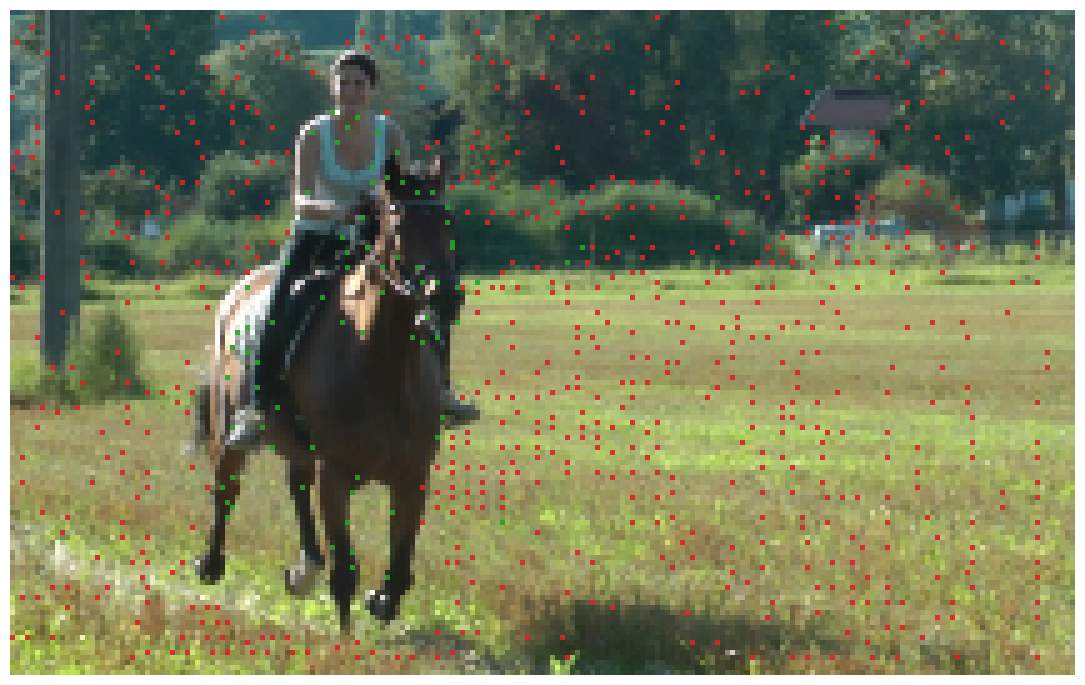

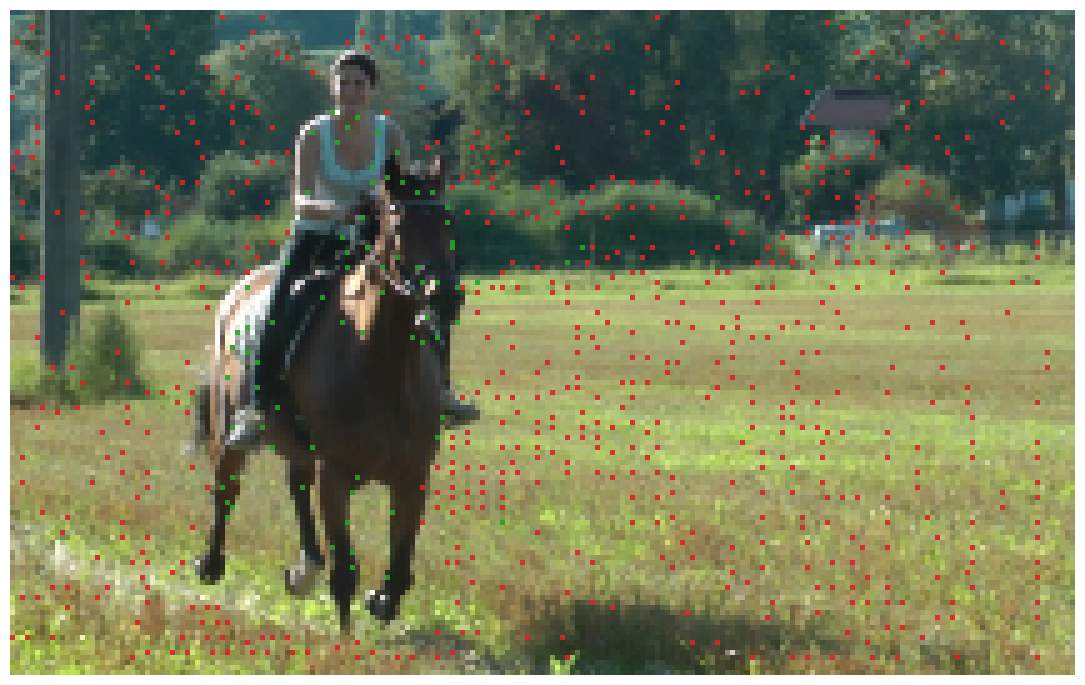

In [43]:
from scipy.interpolate import interp2d
import torch.nn.functional as F
import torch

@saveable()
def plot_grid_scribbles(image, 
                         fg, bg, 
                         color_fg = None, 
                         color_bg = None, 
                         size: float = 5,
                         tight: bool = True):
    if color_fg is None:
        color_fg = plt.get_cmap("tab10").colors[2]
    if color_bg is None:
        color_bg = plt.get_cmap("tab10").colors[3]
   
    thresh = 0.1
    def subsample(img: np.ndarray):
        x = torch.arange(-1, 1, 6 / img.shape[-2])
        y = torch.arange(-1, 1, 6 / img.shape[-1])
        xx, yy = torch.meshgrid(x, y)
        flowgrid = torch.stack((yy, xx), dim=-1).float()[None,...]
        return F.grid_sample(img[None,...], flowgrid, align_corners=True)[0,...]

    subsampled_image = subsample(image).permute(1, 2, 0)
    extent = (0, subsampled_image.shape[1], subsampled_image.shape[0], 0)

    fig = plt.figure(figsize=(size, size))

    #x_ext = sizes[1] / dpi, sizes[0] / dpi
    if tight:
        sizes = subsampled_image.shape[:2]
        dpi = 300
        fig.set_size_inches(15 * (sizes[1]-1) / dpi, 15 * (sizes[0]-1) / dpi, forward = False)
    
    ax = plt.Axes(fig, [0., 0., 1, 1])
    
    ax.set_axis_off()
    ax = fig.add_axes(ax, computed_zorder=False)
    
    ax.imshow(subsampled_image, extent=extent)

    #ax.pcolormesh(subsampled_image, edgecolors="#a2a6ab", linewidth=.5, facecolors='none',rasterized=True, zorder=0)

    sub_fg = subsample(torch.tensor(fg.unsqueeze(0).float()))[0]
    sub_fg = (sub_fg > thresh).float()
    fg_pred_color = np.zeros(sub_fg.shape + (4,), dtype=np.float32)

    fg_pred_color[..., 0:3] = color_fg
    alpha_fg_scribble = .9
    fg_pred_color[..., 3] = sub_fg * alpha_fg_scribble

    ax.imshow(fg_pred_color, extent=extent)


    sub_bg = subsample(torch.tensor(bg.unsqueeze(0).float()))[0]
    sub_bg = (sub_bg > thresh).float()
    bg_pred_color = np.zeros(sub_bg.shape + (4,), dtype=np.float32)

    bg_pred_color[..., 0:3] = color_bg
    alpha_bg_scribble = .9
    bg_pred_color[..., 3] = sub_bg * alpha_bg_scribble

    ax.imshow(bg_pred_color, extent=extent)

    ax.set_ylim(bg_pred_color.shape[0]-1, 0)
    ax.set_xlim(0, bg_pred_color.shape[1]-1,)
   
    x_pos = [i._x for i in ax.get_xticklabels() if i._x <= subsampled_image.shape[1]]
    x_lab = [round((i / subsampled_image.shape[1]), 2) for i in x_pos]
    x_lab = ["" for x in x_lab]
    ax.set_xticks(x_pos, x_lab)

    y_pos = [i._y for i in ax.get_yticklabels() if i._y <= subsampled_image.shape[0]]
    y_lab = [round((i / subsampled_image.shape[0]), 2) for i in y_pos]
    y_lab = ["" for x in y_lab]
    ax.set_yticks(y_pos, y_lab)

    return fig

fig = plot_grid_scribbles(img_no_blur, fg_no_proc, bg_no_proc,
                     save=True,
                     override=True, 
                     tight_layout=True,
                     path=f"./notebooks/output/intro_figures/teaser_image_pc_scribbles_{dataset_name}_{index}", 
                     tight=True,
                     ext=["png", "pdf"])
fig

In [14]:
subsampled_image.shape[2]

NameError: name 'subsampled_image' is not defined

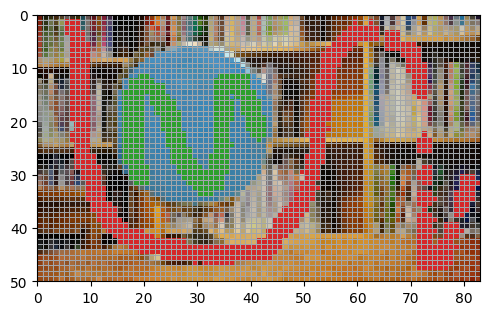

In [ ]:

fig.get_axes()[0].get_xticklabels()
fig

In [ ]:
for lab in fig.get_axes()[0].get_xticklabels():
    idx = lab._x
    img_x = round((image.shape[2] / idx), 1)
    lab.set_text(f"{img_x}")

C:\Users\Schneider\AppData\Local\Temp\ipykernel_6588\324262745.py:3: RuntimeWarning: divide by zero encountered in scalar divide
  img_x = round((image.shape[2] / idx), 1)


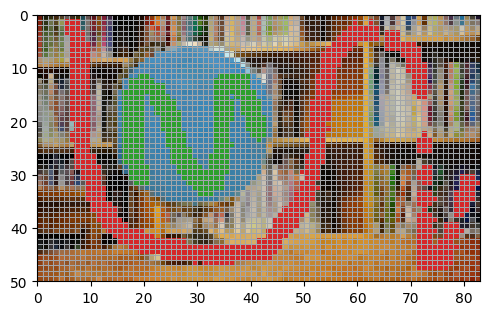

In [ ]:
fig

In [ ]:
sub_fg.unique()

NameError: name 'sub_fg' is not defined

In [ ]:
image

tensor([[[0.4000, 0.3255, 0.1373,  ..., 0.7216, 0.7804, 0.5529],
         [0.4471, 0.3922, 0.1725,  ..., 0.7333, 0.7843, 0.5608],
         [0.5137, 0.4235, 0.2039,  ..., 0.7216, 0.7765, 0.4510],
         ...,
         [0.6078, 0.6353, 0.6000,  ..., 0.6510, 0.5725, 0.5216],
         [0.5765, 0.6431, 0.5804,  ..., 0.6314, 0.5412, 0.5490],
         [0.5608, 0.6196, 0.5961,  ..., 0.5529, 0.5569, 0.5451]],

        [[0.0941, 0.0980, 0.0706,  ..., 0.5922, 0.6863, 0.4824],
         [0.1216, 0.1529, 0.0980,  ..., 0.6000, 0.6902, 0.4824],
         [0.1333, 0.1451, 0.1255,  ..., 0.5922, 0.6784, 0.3686],
         ...,
         [0.2941, 0.3294, 0.2941,  ..., 0.2745, 0.1922, 0.1412],
         [0.2745, 0.3373, 0.2745,  ..., 0.2549, 0.1608, 0.1804],
         [0.2588, 0.3176, 0.2980,  ..., 0.1765, 0.1882, 0.1765]],

        [[0.0431, 0.0431, 0.0078,  ..., 0.4706, 0.5529, 0.3412],
         [0.0588, 0.0824, 0.0314,  ..., 0.4627, 0.5490, 0.3373],
         [0.0588, 0.0667, 0.0314,  ..., 0.4314, 0.5176, 0.

In [ ]:
F.grid_sample

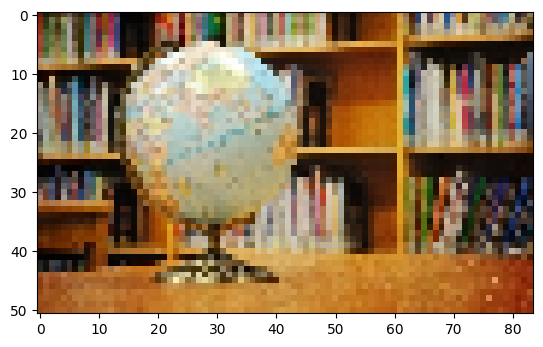

In [ ]:
from scipy.signal import resample

plt.figure()

plt.imshow(image.permute(1, 2, 0)[::3, ::3, :])

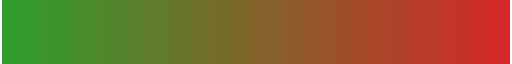

In [ ]:
cmap

In [ ]:
to_hex(color_bg)

'#d62728'